# Laplace description of the transient in dynamical systems

This notebook aims to show how the linearised Laplace description of a dynamical system can be used to predict key parameters of the transient of a dynamical system.

We use a series of simple dynamical systems, starting with a free harmonic oscillator, and then progressing to self-oscillating systems with one and several vibrating modes, arriving at a simplified model of a reed instrument with an upstream and a downstream resonator. 

## Model descriptions

One of the key assumptions is that all these systems, even the self-oscillating ones, can be described as a set of free oscillators excited by an initial perturbation. 

Self-oscillating systems are seen simply as free oscillators where the damping is negative. In order for the oscillation to stop growing, it is necessary to include a non-linearity in the (negative) damping of the system (or maybe in the stiffness??) 


## Method

For each of the systems below, we start by describing the system, then simulate it, decompose the obtained signal using the Heterodyn method, and then using the Laplace description, try to explain the transient characteristics that we observe.


In [19]:
%pylab inline
import sympy as sy
from sympy.parsing.sympy_parser import parse_expr
import scipy.signal as sig
from IPython.display import Markdown as md
from IPython.display import Audio, display


Populating the interactive namespace from numpy and matplotlib


### Heterodyne analysis

The **aim**  of this method is to decompose the signal $y(t)$ , solution of the dynamical system, into sinusoideal partials with slowly-varying amplitudes and frequencies.

For this method, a series of **frequencies of interest** $f_i$ have to be selected at first.

For each of these frequencies $f_i$, the signal $y(t)$ is analysed by multiplying it by the signal $x_{ref,i}(t) = e^{j 2\pi f_i t} $, and then summing the result over a window of finite length (after modulating with a Hann window)

The partial is then **resynthesised** and subtracted from the original signal. Doing this reduces the bias in the next partials by reducing spectral leakage from one component to the next. 
> **Idea**: use an iterative method to also reduce the bias introduced by higher partials in the analysis of the lower ones

The **result** is a complex vector per partial, where different elements of the vector correspond to different time values along the signal. The module of this vector corresponds to the amplitude of the partial, and the phase is a relative phase difference between the signal $x_{ref,i}(t)$ and the

The **instantaneous frequencies** are then estimated by integrating the phase difference between the partial and the reference signal. 

In [200]:
from pypevoc.Heterodyne import heterodyne
import timeseries as ts

def heterodyne_corr(x,sr,f,maxwind=2**14,nhop=2**10,nper=3,dc_cut=50, release_partials=True, interp_mode='exp'):
    #c1,_ = heterodyne(x,x,wind=np.hanning(nwind),hop=nhop)
    xx = x.copy()
#     newn = int(len(xx)/sr*dc_cut)
#     x2 = np.concatenate((xx,np.zeros(int((newn+1)*sr/dc_cut))))
#     print(newn,x2.shape)
#     xd = sig.resample(x2,newn)
#     xu = sig.resample(xd,len(x2))[:len(xx)]
#     xx -= xu
    t = np.arange(len(x))/sr
    #npts = len(c1)
    nharm = len(f)
    #camp = np.zeros((npts,nharm),dtype='complex')
    ret = []
    farr = []

    part = np.zeros((len(x),nharm))
    for ii,ff in enumerate(f):
        #nwind = int(min(maxwind,sr/ff*nper))
        if ff==0.:
            nwind=maxwind
        foth = np.delete(f,ii)
        nwind = (sr/np.min(np.abs(foth-ff))*nper)
        print(nwind)
        hetsig = np.exp(1j*2*np.pi*ff*t)
        if release_partials:
            cc,ih = heterodyne(xx,hetsig,wind=np.hanning(nwind),hop=nhop)
        else:
            cc,ih = heterodyne(x,hetsig,wind=np.hanning(nwind),hop=nhop)
        if ff==0.:
            cc/=2
        th=ih/sr
        ret.append(ts.SampledTimeSeries(cc,th,label='%.2f'%ff))
        ret[-1].f = ff
        if interp_mode[:3] == 'lin':
            hf = np.interp(t,th,cc)
        elif interp_mode[:3] == 'exp':
            hfa = np.exp(np.interp(t,th,np.log(np.abs(cc))))
            hfp = np.interp(t,th,np.unwrap(np.angle(cc)))
            hf = hfa*np.exp(1j*hfp)
        xp = np.real(np.conjugate(hf)*hetsig)
        

        if interp_mode[:3] == 'lin':
            ax = interp(t,th,(np.abs(cc)))
        elif interp_mode[:3] == 'exp':
            ax = np.exp(interp(t,th,np.log(np.abs(cc))))

        cc,ih = heterodyne(xx/ax,hetsig,wind=np.hanning(nwind),hop=nhop)

        
        fh = ff-np.diff(np.unwrap(np.angle(cc)))/2/pi
        fbc = ts.SampledTimeSeries(fh,(th[1:]+th[:-1])/2,label='%.2f%ff (freq)')
        farr.append(fbc)

        xx-=xp
        part[:,ii]=xp

    return ret,farr,xx,part



## Simulation method

For simulation, the dynamical system as a system of first-order differential equations. 

The system evolves in free-mode (no external forcing) for most of the simulation, except for the *perturbation* time, where an external forcing is imposed. This triggers the oscillations that then decay or rise depending on the overal damping of the system. 

The time-course of the perturbation can be changed. By default we are using the expression:

$$u_{ext} (t) = U_0\sin\left(2\pi \left(\frac{t}{T_{pert}}+1\right)\right)$$, for $$t\in[-T_{pert},0]$$  

These are then integrated using a general-purpose solver from python's scipy library.

The integration is separated into two parts, the first one during the perturbation using a smaple rate that insures $N_{points}$ (100 by default) during the perturbation time, and a scond one with a fixed sample rate. 

$U_0$ is determined in order to have a known integral that provides a constant perturbation amplitude $U_{ampl}$  independent of the duration of the pulse. For example, If $U_{ampl}=1$:

$$ \int_{-T_{pert}}^{0} {u_{ext}(t) dt} = 1 $$
$$ U_0 \left[-\frac{T_{pert}}{2\pi} \cos\left(2\pi\frac{t}{T_{pert}} +1\right)\right]_{-T_{pert}}^{0} = 1$$
$$ U_0 = \frac{\pi}{T_{pert}} $$

In [340]:
from scipy.integrate import ode, odeint, complex_ode
from functools import partial

def odeintz(func, z0, t, **kwargs):
    """An odeint-like function for complex valued differential equations."""

    # Disallow Jacobian-related arguments.
    _unsupported_odeint_args = ['Dfun', 'col_deriv', 'ml', 'mu']
    bad_args = [arg for arg in kwargs if arg in _unsupported_odeint_args]
    if len(bad_args) > 0:
        raise ValueError("The odeint argument %r is not supported by "
                         "odeintz." % (bad_args[0],))

    # Make sure z0 is a numpy array of type np.complex128.
    z0 = np.array(z0, dtype=np.complex128, ndmin=1)

    def realfunc(x, t, *args):
        z = x.view(np.complex128)
        dzdt = func(z, t, *args)
        # func might return a python list, so convert its return
        # value to an array with type np.complex128, and then return
        # a np.float64 view of that array.
        return np.asarray(dzdt, dtype=np.complex128).view(np.float64)

    result = odeint(realfunc, z0.view(np.float64), t, **kwargs)

    if kwargs.get('full_output', False):
        z = result[0].view(np.complex128)
        infodict = result[1]
        return z, infodict
    else:
        z = result.view(np.complex128)
        return z


class ImpRespSolver(object):
    def __init__(self, f, f_args=None,
                 impulse_expr="(sin((t/duration)*pi)/duration)", 
                 impulse_duration=1.0, impulse_ampl=1.0,
                 t_before_impulse=0.0, y0=None, t_max=10.0, n_impulse_points=1000,
                 sr = 1.0,
                 is_complex=False):
        
        base_expr = parse_expr(impulse_expr)
        duration = impulse_duration
        t_before_impulse_ = (np.round(t_before_impulse*sr))/sr
        self.t_start = -t_before_impulse_ - impulse_duration
        self.t_impulse_start = -impulse_duration
        self.t_impulse_end = 0.0
        self.t_max = t_max
        self.f = f
        self.sr = sr
        if y0 is None:
            import inspect
            nargs = np.sum([pp.default is inspect._empty for k,pp in inspect.signature(f).parameters.items()])-2
            y0=np.zeros(nargs)
        self.y0=y0
        self.args=f_args
        self.n_impulse_points = n_impulse_points
        
        base_expr = parse_expr(impulse_expr)
        base_expr = base_expr.subs({'duration':duration,'t0':self.t_impulse_start})*impulse_ampl

        self.fsy = sy.lambdify('t',base_expr)
        self.dfsy = sy.lambdify('t',base_expr.diff())
        self.is_complex = is_complex
        
    def segment_integrate(self, t_start, t_end, y_start, f_ext_on=False, n=100):
        t = np.linspace(t_start,t_end,n)
        args = self.args
        
        if f_ext_on:
            args += (self.fsy, self.dfsy)
            force = self.fsy(t-self.t_impulse_start)
        else:
            force = np.zeros(t.shape)

        if self.is_complex:
            sol = odeintz(f, y_start, t, args=args)
        else:
            sol = odeint(f, y_start, t, args=args)
            
            
        return t, sol, force
    
    def integrate(self):
        y0=self.y0
        allt = []
        ally = []
        allx = []
        t_seg=[]
        f_seg=[]
        dt_seg=[]
        if self.t_start < self.t_impulse_start:
            t_seg.append(self.t_start)
            f_seg.append(False)
            dt_seg.append(1/self.sr)
        t_seg+=[self.t_impulse_start,self.t_impulse_end,self.t_max]
        f_seg+=[True,False]
        dt_impulse = (self.t_impulse_end-self.t_impulse_start)/self.n_impulse_points
        dt_seg+=[dt_impulse,1/self.sr]
        for ts, te, f_ext, dt in zip(t_seg[:-1],t_seg[1:],f_seg, dt_seg):
            n = int((te-ts)/dt)
            print(ts,te,f_ext,n)
            t,y,x=self.segment_integrate(ts, te, y0, f_ext_on=f_ext,n=n)
            y0 = y[-1]
            allt.append(t)
            ally.append(y)
            allx.append(x)
        
        irs.idx_ir_start = np.sum([len(xx) for xx in allt[:-1]])
            
        return np.concatenate(allt),np.concatenate(ally),np.concatenate(allx)
    
    


## Single acoustic mode, free

Here we simulate one acoustic mode excited by a flow  pulse

### Mathematical model

The equation for the single-mode free acoustic resonator is

$$ \frac{d^2 p}{dt^2} + \frac{\omega_0}{Q_0} \frac{d p}{dt} + \omega_b^2 p = \frac{Z_0 \omega_0}{Q_0}  \frac{d u}{dt}$$

Where $u(t)$ is the flow source. In this case, flow is only due to the external pulse that excites the oscillator in the beginning. 

$$u(t) =  u_{ext}(t)$$


In [341]:
# Mode parameters
omega_0 = 2*pi
q_0=5
z_0=1.0*4


#### Writing the dynamical system as a first-order equation 

The above differential equation is decomposed in two, by setting

$$ q = \frac{dp}{dt} $$

It then becomes

$$ \begin{align}
\frac{dp}{dt} &= q \\
\frac{dq}{dt} &= -\frac{\omega_0}{Q_0} q - \omega_b^2 p + \frac{Z_0 \omega_0}{Q_0}  \frac{d u}{dt}
\end{align}$$

-0.01 0.0 True 999
0.0 100 False 80000


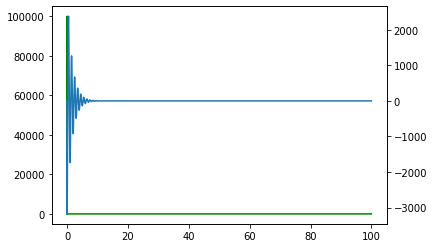

In [342]:

def f(y, t, omega_0, Q, Z_0, u_ext=None, du_ext=None):
    p, dp = y
    if du_ext is None:
        dydt = [dp, - omega_0/Q * dp - omega_0**2*p]
    else:
        dydt = [dp, - omega_0/Q * dp - omega_0**2*p + Z_0*omega_0/Q * du_ext(t)]
    return dydt

idur = .01
t_max=100
impulse_ampl = 1000

irs = ImpRespSolver(f,(omega_0,q_0,z_0),y0=[0,0],t_max=t_max,sr=800,impulse_duration=idur,impulse_ampl=impulse_ampl)
t,y,x=irs.integrate()
fig,ax=subplots(1)
ax.plot(t,x,color='g')
ax2 = ax.twinx()
ax2.plot(t,y[:,0])

### Extracting the partial amplitudes and phases using the Heterodyne method

In [343]:
hh,hf,res,part=heterodyne_corr(y[irs.idx_ir_start:,0],irs.sr,omega_0/2/pi*np.arange(5),
                            maxwind=2**12,nhop=2**10,nper=3,dc_cut=50, 
                            release_partials=True,interp_mode='exp')


2400.0
2400.0
2400.0
2400.0
2400.0


## Laplace description

We replace $p(t) = p\, e^{s t}$ and $u(t) = u\, e^{s t}$, where $s$ is the complex-valued Laplace variable that contains information about the frequency and the exponential rate of the response:

$$ \left(s^2 + \frac{\omega_0}{Q_0} s  + \omega_0^2\right) p = \frac{Z_0 \omega_0}{Q_0}  s\;u $$



$$  p = \frac{\frac{Z_0 \omega_0}{Q_0} s }{s^2 + \frac{\omega_0}{Q_0} s  + \omega_0^2} u $$

In the free oscillating regime
$$ u=0$$

This means that the denominator must vanish for p to have a finite value

$$ \left(s^2 + \frac{\omega_0}{Q_0} s  + \omega_0^2\right) = 0$$

$$ s = -\left(\frac{\omega_0}{2 Q_0}\right) \pm \sqrt{\frac{\omega_0^2}{4 Q_0^2} - \omega_0^2} $$

$$ s = -\left(\frac{\omega_0}{2 Q_0}\right) \pm \omega_0 \sqrt{\frac{1}{4 Q_0^2} - 1} $$

$$ s = -\left(\frac{\omega_0}{2 Q_0}\right) \pm j \omega_0 \sqrt{1-\frac{1}{4 Q_0^2}} $$


#### Initial amplitude of the perturbation

The perturbation is set to have an integral of {{init_ampl}}

### Comparison to model

Next we calculate the expected value of $s$ in the free regime, and from this value we can also calculate:
1. $f_0={\Im{(s)}}/{2\pi}$ the oscillation frequency 
2. $\alpha = \Re{(s)}$ the exponential decay rate (this is converted to dB/sec by dividing by 0.115)

The red horizontal lines represent the theoretical values of these values. They are plotted on top of :
1. the instantaneous frequency as determined by the phase difference between adjacent frames of the Heterodyne components
2. the amplitude ratios between adjacent frames

In [344]:
dbps_to_alpha_fact = log(10)/20
print(dbps_to_alpha_fact)

0.11512925464970229


s_0 = (-0.6283185307179586+6.251690445656587j)
f_0 = 0.99498743710662 Hz
alpha = -5.457505415367365 


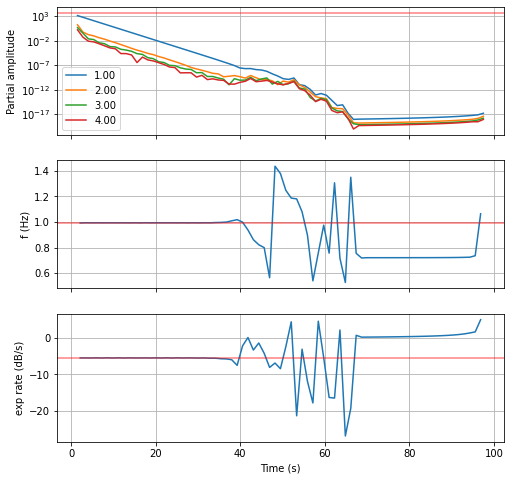

In [345]:
#import warnings
#warnings.filterwarnings("error")
s0 = -omega_0/2/q_0 + 1j*omega_0*sqrt(1-1/4/q_0**2) 
print(f's_0 = {s0}')
print(f'f_0 = {s0.imag/2/pi} Hz')
print(f'alpha = {s0.real/dbps_to_alpha_fact} ')
p_0 = omega_0/q_0*z_0*impulse_ampl * np.abs(s0)/s0.imag

fig,ax = subplots(3,sharex=True,figsize=(8,8))

for hn in hh[1:]:
    ha = hn.apply(abs)
    ha.label = hn.label
    ha.plot(ax=ax[0])
ax[0].axhline(p_0,color='r',alpha=.5)


ax[0].set_yscale('log')
ax[0].grid()
ax[0].set_ylabel('Partial amplitude')
ax[0].legend()

hn=hf[1]
hn.plot(ax=ax[1])
ax[1].axhline(s0.imag/2/pi,color='r',alpha=.5)
ax[1].grid()
ax[1].set_ylabel('f (Hz)')

hh[1].apply(lambda x: 20*np.log10(np.abs(x))).diff().plot(ax=ax[2])
ax[2].axhline(s0.real/dbps_to_alpha_fact,color='r',alpha=.5)
ax[2].set_ylabel('exp rate (dB/s)')
ax[2].set_xlabel('Time (s)')
ax[2].grid()


In [346]:
np.abs(omega_0/q_0*z_0*impulse_ampl / (1+omega_0/q_0/s0+omega_0**2/s0**2))

3.6220097290385613e+19

In [347]:
1+omega_0**2/s0**2

(0.02000000000000013+0.19899748742132392j)

## Single acoustic mode, self-oscillating

Here we simulate one acoustic mode with a piece-wise constant self-excitation, and externally excited by a flow  pulse

### Mathematical model

The equation for the single-mode free acoustic resonator is

$$ \frac{d^2 p}{dt^2} + \frac{\omega_0}{Q_0} \frac{d p}{dt} + \omega_0^2 p = \frac{Z_0 \omega_0}{Q_0}  \frac{d u}{dt}$$

Where $u(t)$ is the flow source. In this case, flow is only due to the external pulse that excites the oscillator in the beginning. 

$$u(t) =  u_B(p) + u_{ext}(t)$$

$u_B$ could represent the Bernoulli flow from a constant pressure source $p_m$ through a valve:

$$u_B(p) = \sqrt(\frac{2}{\rho})sqrt(p_m - p) (p_M-p_m+p)$$ 

But for simplicity we will just set it to a decreasing linear function $A p +B$ so that the derivative

$u_B'(p) = A$, for $p\in[-p_{sat},p_{sat}]$ and 0 otherwise, so that in the range  $p\in[-p_{sat},p_{sat}]$ we have

$$ \frac{d^2 p}{dt^2} + \frac{\omega_0}{Q_0} \frac{d p}{dt} + \omega_b^2 p = \frac{Z_0 \omega_0}{Q_0} \left(A \frac{dp}{dt} + u_{ext}(t)\right)$$

or 

$$ \frac{d^2 p}{dt^2} + \frac{\omega_0}{Q_0}\left(1 -Z_0 A \right) \frac{d p}{dt} + \omega_b^2 p =   u_{ext}(t) $$


for $A>1/Z_0$, the effective damping becomes negative and the oscillation should grow

In [348]:
# Mode parameters
omega_0 = 2*pi*4
q_0=3
z_0=.1

#### Writing the dynamical system as a first-order equation 

The above differential equation is decomposed in two, by setting

$$ q = \frac{dp}{dt} $$

It then becomes

$$ \begin{align}
\frac{dp}{dt} &= q \\
\frac{dq}{dt} &= -\frac{\omega_0}{Q_0} q - \omega_0^2 p + \frac{Z_0 \omega_0}{Q_0}  \frac{d u}{dt}
\end{align}$$

-0.001 0.0 True 1000
0.0 100 False 80000


(0.0, 20.0)

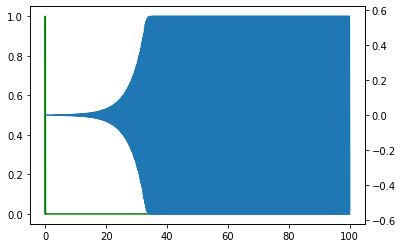

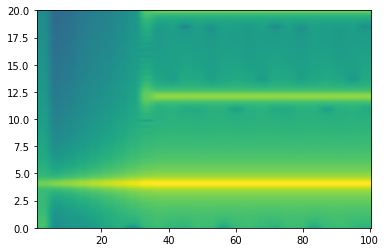

In [357]:

a = 10.5
x0=-.5

#fnl = sy.lambdify('x',fnl_sym.subs([('x0',x0),('a',a)]))
#dfnl = sy.lambdify('x',dfnl_sym.subs([('b',bb),('a',aa)]))
def dfnl(x):
    if x<x0:
        return 0
    elif x>x0+1:
        return 0
    else:
        return a#*(1+2*x*x)

def f(y, t, omega_0, q_0, z_0, u_ext=None, du_ext=None):
    p, dp = y
    dux = 0
    if du_ext is not None:
        dux = du_ext(t)
    
    dydt = [dp, - omega_0/q_0 * dp - omega_0**2*p + z_0 * omega_0 / q_0 * (dfnl(p) * (dp) + dux)]
    return dydt


idur = .001
t_max=100
impulse_ampl = .001

irs = ImpRespSolver(f,(omega_0,q_0,z_0),y0=[0,0],t_max=t_max,sr=800,
                    impulse_duration=idur,impulse_ampl=impulse_ampl)
t,y,x=irs.integrate()
fig,ax=subplots(1)
ax.plot(t,x,color='g')
ax2 = ax.twinx()
ax2.plot(t,y[:,0])
#xlim([0,10])
figure()
specgram(y[:,0],Fs=irs.sr,NFFT=2**12,noverlap=2**10);
ylim([0,20])

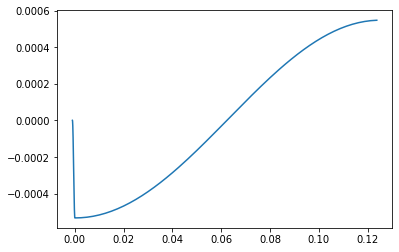

In [358]:
figure()
N=1100
plot(t[:N],y[:N,0])

### Extracting the partial amplitudes and phases using the Heterodyne method

In [375]:
hh,hf,res,part=heterodyne_corr(y[irs.idx_ir_start:,0],irs.sr,omega_0/2/pi*np.arange(5),
                            maxwind=2**12,nhop=2**10,nper=5,dc_cut=50, 
                            release_partials=True,interp_mode='exp')


1000.0
1000.0
1000.0
1000.0
1000.0


## Laplace description

We replace $p(t) = p\, e^{s t}$ and $u(t) = u\, e^{s t}$, where $s$ is the complex-valued Laplace variable that contains information about the frequency and the exponential rate of the response:

$$ \left(s^2 + \frac{\omega_0}{Q_0} s  + \omega_0^2\right) p = \frac{Z_0 \omega_0}{Q_0}  s\;u $$



$$  p = \frac{\frac{Z_0 \omega_0}{Q_0} s }{s^2 + \frac{\omega_0}{Q_0}(1-Z_0 A) s  + \omega_0^2} u_{ext} $$

In the free oscillating regime
$$ u=0$$

This means that the denominator must vanish for p to have a finite value

$$ \left(s_0^2 + \frac{\omega_0}{Q_0}(1-Z_0 A) s_0  + \omega_0^2\right) = 0$$

$$ s_0 = -\left(\frac{\omega_0}{2 Q_0}\right)(1-Z_0 A) \pm \sqrt{\frac{\omega_0^2}{4 Q_0^2}(1-Z_0 A)^2 - \omega_0^2} $$

$$ s_0 = (Z_0 A - 1)\left(\frac{\omega_0}{2 Q_0}\right) \pm \omega_0 \sqrt{\frac{(1-Z_0 A)^2}{4 Q_0^2} - 1} $$



#### Initial amplitude of the perturbation

The perturbation is set to have an integral of $u_0$, and if short enough it can be considered as a unit step with integral value of $u_0$:

$$ u(t) = u_0 \delta(t) $$

The response fo the system to such an impulse is 

$$ \frac{d^2 p}{dt^2} + \frac{\omega_0}{Q_0}\left(1 -Z_0 A \right) \frac{d p}{dt} + \omega_b^2 p = \frac{d}{dt} (u_0\delta(t)) $$

integrating twice, and knowing that $p(t) = p_0 e^{s_0 t}$: 

$$  p_0 e^{s_0 t} + \frac{\omega_0}{Q_0}\left(1 -Z_0 A \right)   \frac{p_0 e^{s_0 t}}{s_0} + \omega_b^2 \frac{p_0 e^{s_0 t}}{s_0^2} =  \frac{Z_0 \omega_0}{Q_0}u_0 H(t) $$


and, at t=0:

$$ p_0 = \frac{\frac{Z_0 \omega_0}{Q_0}u_0}{1 + \frac{\omega_0}{Q_0}\frac{\left(1 -Z_0 A \right)} {s_0}  + \frac{\omega_b^2}{s_0^2}} $$


### Comparison to model

Next we calculate the expected value of $s$ in the free regime, and from this value we can also calculate:
1. $f_0={\Im{(s)}}/{2\pi}$ the oscillation frequency 
2. $\alpha = \Re{(s)}$ the exponential decay rate (this is converted to dB/sec by dividing by 0.115)

The red horizontal lines represent the theoretical values of these values. They are plotted on top of :
1. the instantaneous frequency as determined by the phase difference between adjacent frames of the Heterodyne components
2. the amplitude ratios between adjacent frames

In the first graph, the horizontal <font color='red'>red</font> line is the theoretical value of the initial response to the perturbation:

The <font color='blue'>blue</font> horizontal line is the saturation value, at which the forcing (or negative damping) drops to 0

In [376]:
dbps_to_alpha_fact = log(10)/20
print(dbps_to_alpha_fact)

0.11512925464970229


In [377]:
ath = dfnl(0)
(1-z_0*ath)/q_0

-0.01666666666666668

s_0 = (0.20943951023931973+25.131868548941394j)
f_0 = 3.999861108699762 Hz
alpha = 1.8191684717891232 


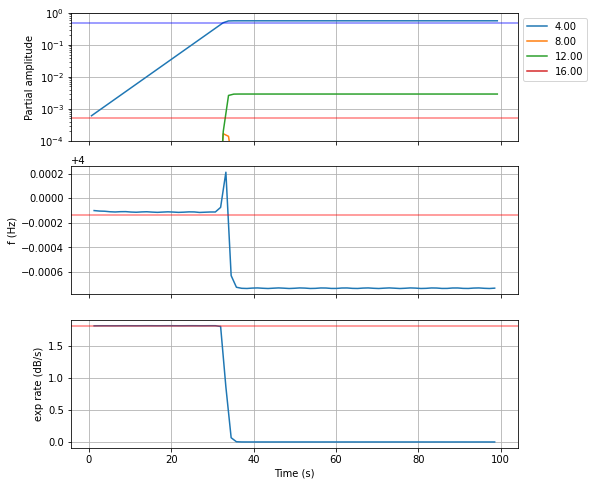

In [388]:
#import warnings
#warnings.filterwarnings("error")
bs = omega_0/q_0*(1-z_0*ath)
s0 = -bs/2 + sqrt((bs/2)**2 - omega_0**2 +0j)
print(f's_0 = {s0}')
print(f'f_0 = {s0.imag/2/pi} Hz')
print(f'alpha = {s0.real/dbps_to_alpha_fact} ')
ia=np.sum(x)*(irs.t_impulse_end-irs.t_impulse_start)/irs.n_impulse_points
p_0 = z_0*omega_0/q_0*np.sqrt(1)*ia

fig,ax = subplots(3,sharex=True,figsize=(8,8))

for hn in hh[1:]:
    ha = hn.apply(abs)
    ha.label = hn.label
    ha.plot(ax=ax[0])
ax[0].axhline(p_0,color='r',alpha=.5)
ax[0].axhline(abs(x0), color='b',alpha=.5)
ax[0].set_ylim(1e-4, 1)

ax[0].set_yscale('log')
ax[0].grid()
ax[0].set_ylabel('Partial amplitude')
ax[0].legend(loc='upper left',bbox_to_anchor=(1,1))

hn=hf[1]
hn.plot(ax=ax[1])
ax[1].axhline(s0.imag/2/pi,color='r',alpha=.5)
ax[1].grid()
ax[1].set_ylabel('f (Hz)')

hh[1].apply(lambda x: 20*np.log10(np.abs(x))).diff().plot(ax=ax[2])
ax[2].axhline(s0.real/dbps_to_alpha_fact,color='r',alpha=.5)
ax[2].set_ylabel('exp rate (dB/s)')
ax[2].set_xlabel('Time (s)')
ax[2].grid()


In [380]:
omega_0,q_0,z_0,ath

(25.132741228718345, 3, 0.1, 10.5)

In [381]:
impulse_ampl,omega_0/q_0*z_0,p_0

(0.001, 0.8377580409572781, 0.0008377653136359766)

[0.15707963+0.00392822j 0.15707963-0.00392822j] [-0.15707963+6.2812215j -0.15707963-6.2812215j]
-0.01 0.0 True 100
0.0 100 False 10000


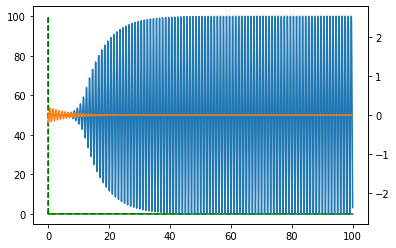

In [107]:
residues,poles,k = sig.residue([z_0*omega_0/q_0,0],[1, omega_0/q_0, omega_0**2])
print(residues,poles)

def f(y, t, pole, residue, u_ext=None, du_ext=None):
    p = y[0]
    if u_ext is None:
        dydt = [ pole * p ]
    else:
        dydt = [ residue * u_ext(t) + pole * p ]
    return dydt


irs = ImpRespSolver(f,(poles[0],residues[0]),y0=[0],t_max=t_max,
                    sr=100,impulse_duration=idur,
                    is_complex=True)
tc,yc,xc=irs.integrate()
fig,ax=subplots(1)
ax.plot(t,x,color='g')
ax.plot(tc,xc,color='g',ls='--')

ax2 = ax.twinx()
ax2.plot(t,y[:,0])
ax2.plot(tc,2*yc.real)


In [386]:
np.sum(x)*(irs.t_impulse_end-irs.t_impulse_start)/irs.n_impulse_points

0.000635982628472229

In [387]:
irs.dfsy

<function _lambdifygenerated(t)>

In [221]:
np.max(y[:,0])

1.3738761902450405

# Two modes

In [336]:
from sympy import Symbol, Heaviside, integrate
from sympy.abc import x,b,a
#fnl_str = "a*((x-x0)**2*((x-x0)/3-1/2)+1)"
#fnl_str = "a*(x-x0)*(x-x0-1)"
#fnl_str = "a*(x-x0)**2"
#fnl_str =  "(a*(1+x-x0)*sqrt(|x0-x|)*sign(x0-x))"
#fnl_sym = parse_expr(fnl_str)
#dfnl_sym = fnl_sym.diff('x')
dfnl_sym = a*x*Heaviside(x-1)*Heaviside(-x)
fnl_sym = integrate(dfnl_sym,x)


a = 2
x0=-.5

#fnl = sy.lambdify('x',fnl_sym.subs([('x0',x0),('a',a)]))
#dfnl = sy.lambdify('x',dfnl_sym.subs([('b',bb),('a',aa)]))
def dfnl(x):
    if x<x0:
        return 0
    elif x>x0+1:
        return 0
    else:
        return a#*(x-x0-1/2)

def f(y, t, omega_b, Q_b, Z_b, omega_v, Q_v, Z_v, u_ext=None, du_ext=None):
    pb, dpb, pv, dpv = y
    dux = 0
    if du_ext is not None:
        dux = du_ext(t)
    
    dydt = [dpb, - omega_b/Q_b * dpb - omega_b**2*pb + z_b * omega_b / Q_b * (dfnl(pb-pv) * (dpb-dpv) + dux),
            dpv, - omega_v/Q_v * dpv - omega_v**2*pv + z_v * omega_v / Q_v * (-dfnl(pb-pv) * (dpb-dpv) - dux)]
    return dydt

#sy.plot(fnl_sym.subs([('x0',x0),('a',a)]),('x',-1,2))
#sy.plot(dfnl_sym.subs([('x0',x0),('a',a)]),('x',-1,2))

-0.01 0.0 True 100
0.0 200 False 20000


(0.0, 100.0)

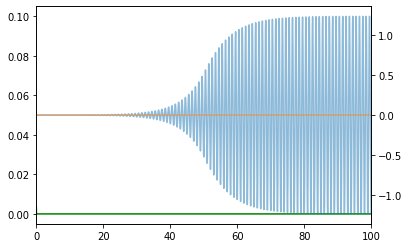

In [340]:
omega_b = 2*pi
q_b=20
z_b=1.0
omega_v = 4*pi
q_v=.001
z_v=1.0/2*q_v

idur=.01
t_max=200

fargs = (omega_b, q_b, z_b, omega_v, q_v, z_v)
sr=100
irs = ImpRespSolver(f,fargs,y0=[0.0,0.0,0.0,0.0],t_max=t_max,
                    sr=sr,impulse_duration=idur,impulse_ampl=0.001)
t,y,x=irs.integrate()
fig,ax=subplots(1)
ax.plot(t,x,color='g')

ax2 = ax.twinx()
ax2.plot(t,y[:,0],alpha=.5)
ax2.plot(t,y[:,2],alpha=.5)
xlim(0,100)

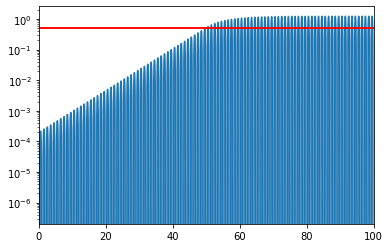

In [341]:
figure()
plot(t,(y[:,0]-y[:,2]))
xlim(0,100)
yscale('log')
axhline(-x0,color='r')
axhline(x0+1,color='r')

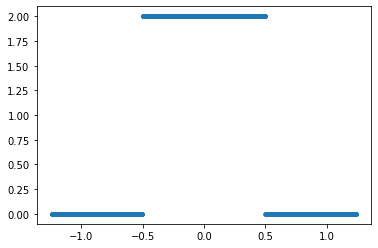

In [342]:
figure()
plot((y[:,0]-y[:,2]),[dfnl(yy) for yy in y[:,0]-y[:,2]],'.')

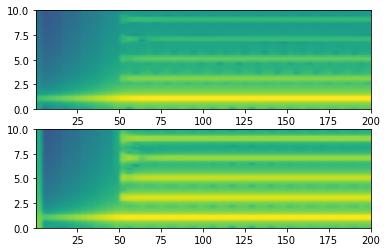

In [343]:
fig,ax=subplots(2)
ax[0].specgram(y[:,0],NFFT=2**9,Fs=sr)
ax[1].specgram(y[:,2],NFFT=2**9,Fs=sr);
for axi in ax:
    axi.set_ylim(0,10)

In [186]:
t

array([0.0000000e+00, 1.0010010e-05, 2.0020020e-05, ..., 1.9959962e+02,
       1.9979981e+02, 2.0000000e+02])

In [1378]:
dp1,dp2,p1,p2 = sy.symbols('dp1,dp2,p1,p2')
dydtvec =  sy.Matrix([dp1, dpfp(p1,dp1,p1+p2,dp1+dp2,omega_1,q1,psat),
                      dp2, dpfp(p2,dp2,p1+p2,dp1+dp2,omega_2,q2,psat)])
dydtjac = dydtvec.jacobian([p1,dp1,p2,dp2])
P1, P2 = sy.symbols('P1,P2')
s = sy.symbols('s')
dydtjacs=dydtjac.subs({p1:0,dp1:0,p2:0,dp2:0})
svals=[x for x in dydtjacs.eigenvals().keys()]
forcingvec = sy.Matrix([0, forcing(1,omega_1,q1, z1),
                        0, forcing(1,omega_2,q2, z2)])

$$ \frac{d^2 p_b}{dt^2} + \frac{\omega_b}{Q_b} \frac{d p_b}{dt} + \omega_b^2 p_b = \frac{Z_b \omega_b}{Q_b}  \frac{d u}{dt}$$
$$  \frac{d^2 p_v}{dt^2} + \frac{\omega_v}{Q_v} \frac{d p_v}{dt} + \omega_v^2 p_v = -\frac{Z_v \omega_v}{Q_v}  \frac{d u}{dt}$$

$$u(t) = u_B(p_v-p_b) + u_{ext}(t)$$


$$ (s^2 + \frac{\omega_b}{Q_b} s  + \omega_b^2) p_b = \frac{Z_b \omega_b}{Q_b}  s u $$
$$  (s^2 + \frac{\omega_v}{Q_v} s  + \omega_v^2) p_v = \frac{Z_b \omega_b}{Q_b}  s (-u) $$

$$u(t) = u_B(p_v-p_b) + u_{ext}(t)$$


$$  p_b = \frac{\frac{Z_b \omega_b}{Q_b} s }{s^2 + \frac{\omega_b}{Q_b} s  + \omega_b^2} u $$
$$  p_v = - \frac{\frac{Z_v \omega_v}{Q_v} s }{s^2 + \frac{\omega_v}{Q_v} s  + \omega_v^2} u  $$

$$u(t) = u_B(p_v-p_b) + u_{ext}(t)$$


$$\frac{d u}{dt} = u_B'(p_v-p_b)(\frac{d p_v}{dt}-\frac{d p_b}{dt}) + u_{ext}(t)$$



$$u(t) = u_B(p_v-p_b) + u_{ext}(t)$$

$$ u(t) \simeq u_B'(\Delta p = 0) (p_v-p_b) $$

$$ u(s) \simeq u_B' (p_v(s) - p_b(s)) $$

$$ u(s) \simeq u_B' \left(- \frac{\frac{Z_v \omega_v}{Q_v} s }{s^2 + \frac{\omega_v}{Q_v} s  + \omega_v^2}    - \frac{\frac{Z_b \omega_b}{Q_b} s }{s^2 + \frac{\omega_b}{Q_b} s  + \omega_b^2} \right) u(s) $$
